## GlADE+ catalog visualization

In this notebook, we use the `healpy` library to visualize the data output from the `parse_catalog` script. We follow the tutorial provided in the [`healpy` documentation](https://healpy.readthedocs.io/en/latest/tutorial.html).

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import healpy as hp

from catalog.utils import GalaxyCatalog, Skymap

In [11]:
# Notebook settings
save_figures = False

In [12]:
# Constants
nside = 32
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 32 is 1.8 deg


Number of pixels in the map:

In [13]:
npix = hp.nside2npix(nside)
npix

12288

Importing file:

In [14]:
catalog_path = '/Volumes/binadohd/phd/GLADE+/parsed_catalog.hdf5'
catalog = GalaxyCatalog(catalog_path)

The `skymap` dataset holds the corresponding pixel for each galaxy. In the cell below, we convert this information into an array of length `npix` holding the number of galaxies within each pixel:

21882387 21882387


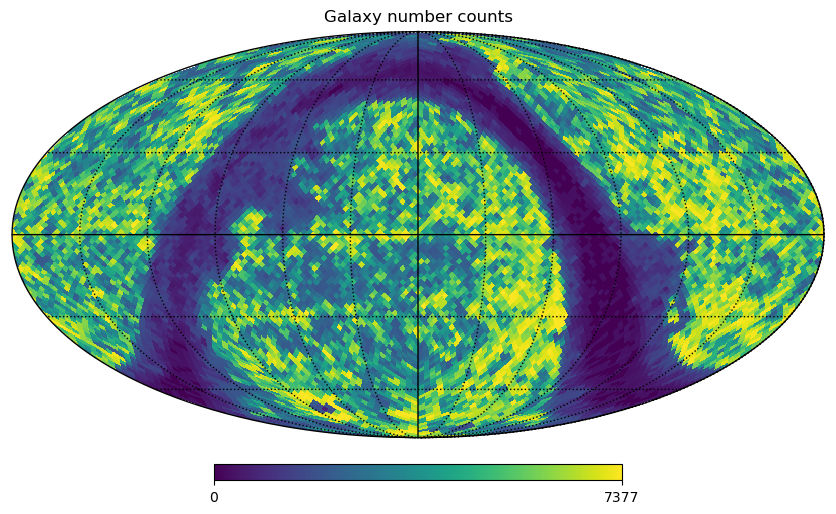

In [15]:
ra, dec = catalog.get('ra'), catalog.get('dec')
print(len(ra), len(dec))
skymap = Skymap(nside, ra, dec)
number_density = skymap.counts()
hp.mollview(number_density, title="Galaxy number counts", norm="hist")
hp.graticule()
if save_figures:
    plt.savefig('figures/galaxy-map.png', dpi=400)
plt.show()

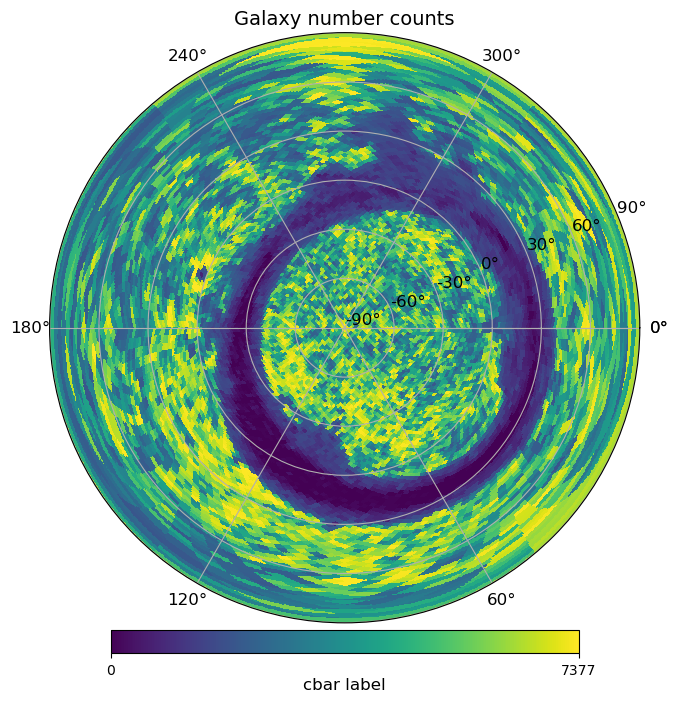

In [16]:
# polar view
hp.projview(
    number_density,
    coord=["G"],
    rot=[0, 90, 180],
    graticule=True,
    graticule_labels=True,
    unit="cbar label",
    norm="hist",
    cb_orientation="horizontal",
    projection_type="polar",
    title="Galaxy number counts",
)
plt.tight_layout()
plt.show()

Histogram of the redshift distribution:

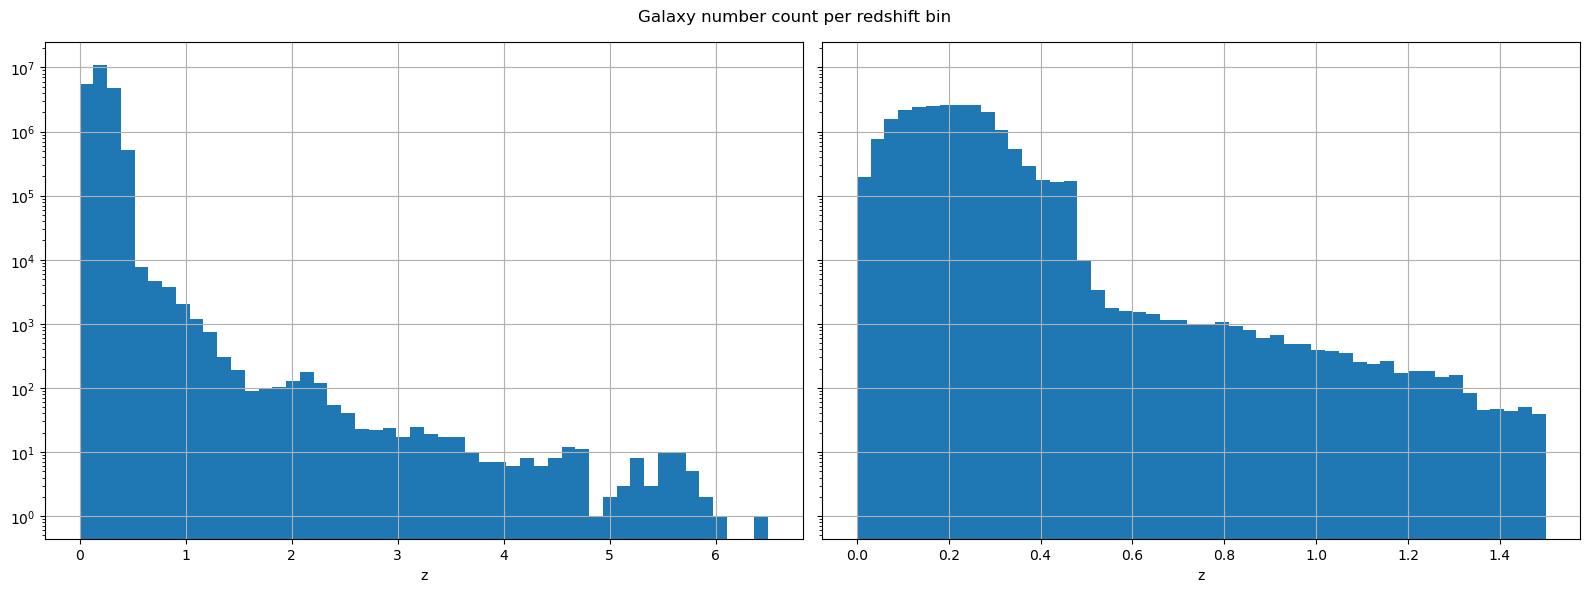

In [17]:
z = catalog.get('z_cmb')
z_max = 1.5
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
ax1.hist(z, bins=50, log=True)
ax2.hist(z[z < z_max], bins=50, log=True)
ax1.set_xlabel('z')
ax2.set_xlabel('z')
ax1.grid()
ax2.grid()
fig.suptitle('Galaxy number count per redshift bin')
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout()
if save_figures:
    fig.savefig('figures/galaxy-redshift-distribution.png', dpi=400)
plt.show()

Mergers within galaxies at $z > 1.5$ are very unlikely to be detected by current-generation detectors. Let us repeat the plot upt to $z_{\text{max}}=1.5$:

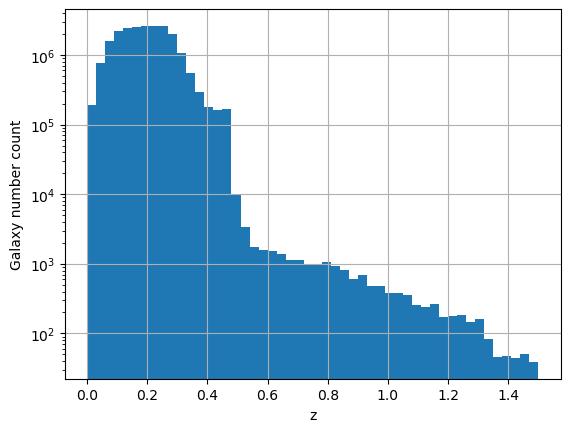

In [18]:
z = catalog.get('z_cmb')
plt.hist(z[z < 1.5], bins=50, log=True)
plt.xlabel('z')
plt.ylabel('Galaxy number count')
plt.grid()
plt.show()